In [1]:
from pyspark.sql.functions import col
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from xgboost import XGBClassifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


spark = SparkSession.builder.config("spark.driver.host", "localhost").config("spark.python.worker.reuse", "false").getOrCreate()
file_path = 'file:///C:/Users/seanz/VSCode_WS/BigData/NFL_PBP_V1.csv'
df = spark.read.csv(file_path, header=True, inferSchema=True)

df = df.withColumn(
    'play_success', 
    F.when(
        (F.col('play_type') == 'run') & (F.col('rush_attempt') == 1) & (F.col('yards_gained') >= 4), 1
    ).when(
        (F.col('play_type') == 'pass') & (F.col('pass_attempt') == 1) & (F.col('yards_gained') >= 4), 1
    ).otherwise(0)
)

window_spec = Window.partitionBy('game_id', 'posteam').orderBy('play_id')
df = df.withColumn(
    'cumulative_rush_attempts', 
    F.sum(F.when((F.col('play_type') == 'run') & (F.col('rush_attempt') == 1), 1).otherwise(0)).over(window_spec)
)

df = df.withColumn(
    'cumulative_pass_attempts', 
    F.sum(F.when((F.col('play_type') == 'pass') & (F.col('pass_attempt') == 1), 1).otherwise(0)).over(window_spec)
)

df = df.withColumn(
    'cumulative_rush_successes', 
    F.sum(F.when(
        (F.col('play_type') == 'run') & (F.col('rush_attempt') == 1) & (F.col('yards_gained') >= 4), 1).otherwise(0)
    ).over(window_spec)
)

df = df.withColumn(
    'cumulative_pass_successes', 
    F.sum(F.when(
        (F.col('play_type') == 'pass') & (F.col('pass_attempt') == 1) & (F.col('yards_gained') >= 4), 1).otherwise(0)
    ).over(window_spec)
)

df = df.withColumn(
    'rush_success_rate', 
    F.when(F.col('cumulative_rush_attempts') > 0, F.col('cumulative_rush_successes') / F.col('cumulative_rush_attempts')).otherwise(0)
)

df = df.withColumn(
    'pass_success_rate', 
    F.when(F.col('cumulative_pass_attempts') > 0, F.col('cumulative_pass_successes') / F.col('cumulative_pass_attempts')).otherwise(0)
)

df = df.withColumn('posteam_leading', F.col('score_differential_post') > 0)
df = df.withColumn('posteam_trailing', F.col('score_differential_post') < 0)
df = df.withColumn('yards_gained', F.col('yards_gained').cast('float'))
df = df.withColumn('shotgun', F.col('shotgun').cast('float'))
df = df.withColumn('no_huddle', F.col('no_huddle').cast('float'))
df = df.withColumn('timeout', F.col('timeout').cast('float'))
df = df.withColumn('posteam_timeouts_remaining', F.col('posteam_timeouts_remaining').cast('float'))
df = df.withColumn('defteam_timeouts_remaining', F.col('defteam_timeouts_remaining').cast('float'))
offensive_playtypes = ['field_goal', 'run', 'punt', 'pass']
df = df.filter(df.play_type.isin(offensive_playtypes))

df_indexed = df.withColumn('play_type_index', 
                           F.when(F.col('play_type') == 'pass', 0)
                            .when(F.col('play_type') == 'run', 1)
                            .when(F.col('play_type') == 'punt', 2)
                            .when(F.col('play_type') == 'field_goal', 3)
                            .otherwise(-1))  

feature_columns = [
    # Field Position & Time
    'yardline_100', 'game_seconds_remaining', 'qtr', 'down', 'goal_to_go', 'ydstogo', 
    'score_differential_post', 'posteam_score_post',

    # Game Context & Situational Awareness
    'quarter_seconds_remaining', 'half_seconds_remaining', 'drive', 'score_differential',

    # Play History (Momentum)
    'play_success', 'cumulative_rush_attempts', 'cumulative_pass_attempts', 
    'cumulative_rush_successes', 'cumulative_pass_successes', 'rush_success_rate', 
    'pass_success_rate', 'posteam_leading', 'posteam_trailing',

    # Critical 3rd/4th Down Context
    'third_down_converted', 'third_down_failed', 'fourth_down_converted', 'fourth_down_failed',

    # Play Consequences
    'incomplete_pass', 'sack', 'touchback', 'interception',

    # Special Teams Indicators
    'punt_blocked', 'punt_inside_twenty', 'punt_in_endzone', 'punt_out_of_bounds'
]


assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
df_vector = assembler.transform(df_indexed)

games = df_vector.select("game_id").distinct().collect()  
train_games = games[:int(0.8 * len(games))] 
test_games = games[int(0.8 * len(games)):]

train_df = df_vector.filter(col("game_id").isin([game["game_id"] for game in train_games]))
test_df = df_vector.filter(col("game_id").isin([game["game_id"] for game in test_games]))

# === 1. CONVERT DATA TO PANDAS === #
train_pandas = train_df.toPandas()
test_pandas = test_df.toPandas()

# Convert feature vectors back to NumPy arrays
X_train = np.array(train_pandas["features"].tolist())
y_train = np.array(train_pandas["play_type_index"].tolist())

X_test = np.array(test_pandas["features"].tolist())
y_test = np.array(test_pandas["play_type_index"].tolist())

# === 2. TRAIN XGBOOST MODEL === #
xgb = XGBClassifier(
    max_depth=9,  
    learning_rate=0.05,  
    n_estimators=200,  
    scale_pos_weight=1,  
    subsample=0.8,  
    colsample_bytree=0.8,  
    random_state=42
)

xgb.fit(X_train, y_train)

# === 3. MAKE PREDICTIONS === #
y_pred = xgb.predict(X_test)

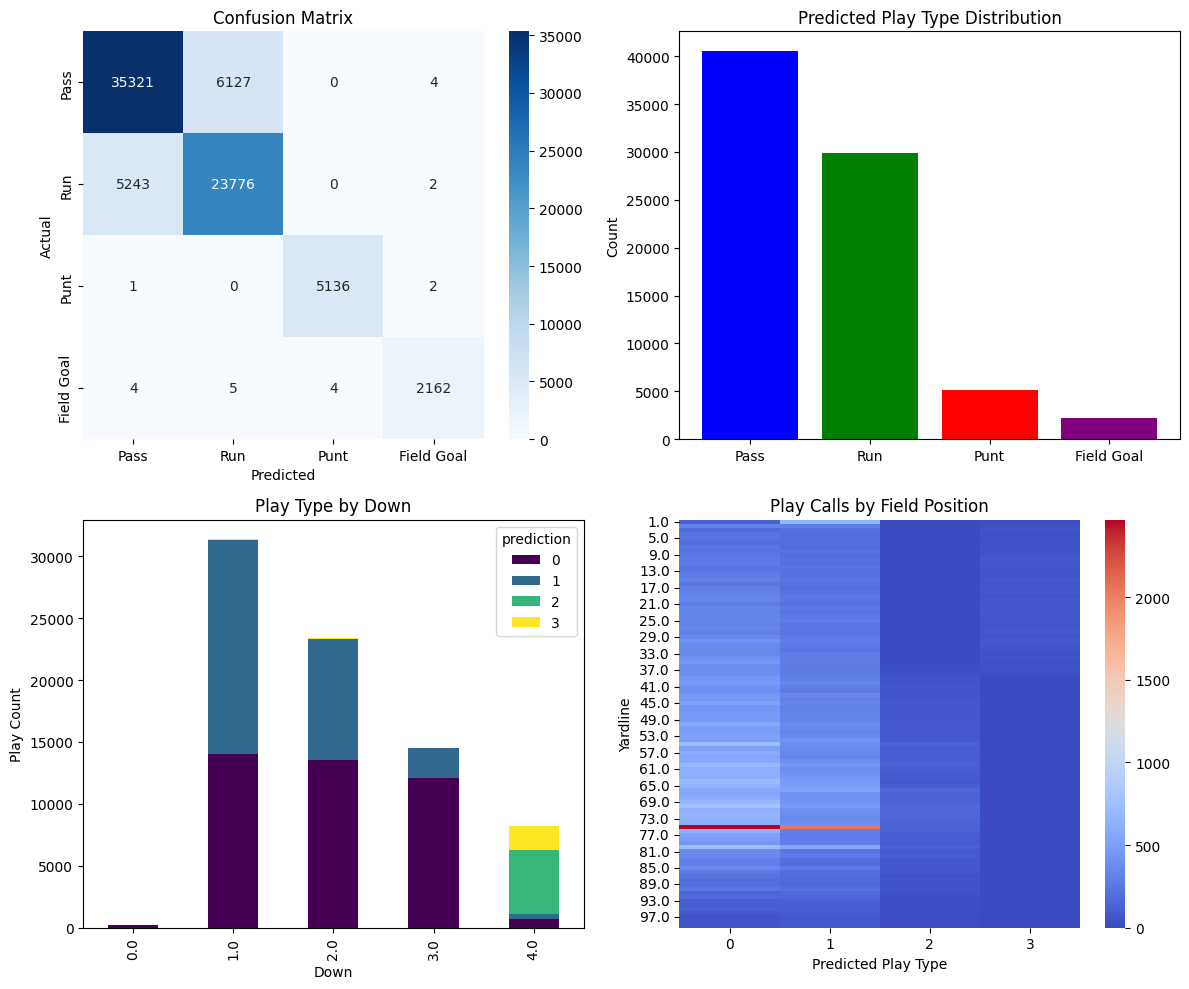

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

# Convert Test Data to Pandas (if not already)
test_pandas = test_df.toPandas()
test_pandas["prediction"] = y_pred  # Add predictions to DataFrame

# Define class labels
class_labels = ["Pass", "Run", "Punt", "Field Goal"]

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# === 🔹 PLOT DASHBOARD === #
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# 🔹 1. Confusion Matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels, ax=ax[0, 0])
ax[0, 0].set_title("Confusion Matrix")
ax[0, 0].set_xlabel("Predicted")
ax[0, 0].set_ylabel("Actual")

# 🔹 2. Play Type Distribution (Bar Chart)
play_counts = test_pandas["prediction"].value_counts().sort_index()
ax[0, 1].bar(class_labels, play_counts, color=["blue", "green", "red", "purple"])
ax[0, 1].set_title("Predicted Play Type Distribution")
ax[0, 1].set_ylabel("Count")

# 🔹 3. Plays by Down (Stacked Bar Chart)
down_play_counts = test_pandas.groupby(["down", "prediction"]).size().unstack(fill_value=0)
down_play_counts.plot(kind="bar", stacked=True, ax=ax[1, 0], colormap="viridis")
ax[1, 0].set_title("Play Type by Down")
ax[1, 0].set_xlabel("Down")
ax[1, 0].set_ylabel("Play Count")

# 🔹 4. Heatmap of Plays by Yardline
heatmap_data = test_pandas.pivot_table(index="yardline_100", columns="prediction", aggfunc="size", fill_value=0)
sns.heatmap(heatmap_data, cmap="coolwarm", ax=ax[1, 1])
ax[1, 1].set_title("Play Calls by Field Position")
ax[1, 1].set_xlabel("Predicted Play Type")
ax[1, 1].set_ylabel("Yardline")

# Adjust layout
plt.tight_layout()
plt.show()